In [39]:
from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
from PIL import Image
import torch
import pandas as pd
import re
import gc
from tqdm import tqdm
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import ast
#import nbimporter
#from making_color_images import segment_outline

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
data_folder = WORK / "color-concept-entanglement" / "data"

fruit = data_folder / "fruit"
color_outlines = data_folder / "color_images"

/mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_images


# Load Model

In [3]:
# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [118]:
def clean_instruction_tokens(text):
    cleaned_text = re.sub(r'\[INST\]\s*\n?.*?\[/INST\]\s*', '', text, flags=re.DOTALL)
    return cleaned_text.strip()


def mllm_testing(df, processor, model, most="True"):
    with torch.inference_mode():
        torch.cuda.empty_cache()
        gc.collect()
        generated_texts = []
        for idx, row in df.iterrows():
            instruction_tokens = "[INST] <image>\n"
            end_tokens = "[/INST]"

            image_type = row['image_type']
            object_name = row['object']
            #question = f"What color is {'a' if most == 'True' else 'this'} {object_name}?"
            if most == "True":
                object_name_plural = object_name if object_name.endswith("s") else object_name + "s"
                question = f"What color are most {object_name_plural}?"

            else:
                question = f"What color is this {object_name}?"

            prompt = f"{instruction_tokens} Answer with one word. {question} {end_tokens}"

            try:
                image = Image.open(row['image_path']).convert("RGB")
                image = image.resize((256, 256), Image.LANCZOS)
            except FileNotFoundError:
                print(f"Warning: Image not found for {row['object']}")
                generated_texts.append(None)
                continue  # Skip to the next row in the DataFrame

            inputs = processor(images=image, text=prompt, return_tensors='pt')
            inputs = {k: v.to(device) for k, v in inputs.items()}
            # Perform a forward pass with the model
            outputs = model.generate(**inputs, max_new_tokens=10, num_beams=1, do_sample=False, temperature=1.0, pad_token_id=processor.tokenizer.eos_token_id)  # Adjust max_new_tokens as needed
            predicted_answer = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
            predicted_answer = clean_instruction_tokens(predicted_answer)

            generated_texts.append(predicted_answer)
            #print(torch.cuda.memory_summary())

            to_delete = ['inputs', 'outputs', 'image_inputs', 'video_inputs', 'generated_ids', 'prepare_inputs', 'image', 'pil_images', 'inputs_embeds']
            for var_name in to_delete:
                if var_name in locals():
                    var = locals()[var_name]
                    if isinstance(var, dict):
                        for v in var.values():
                            if torch.is_tensor(v) and v.is_cuda:
                                del v
                    elif torch.is_tensor(var) and var.is_cuda:
                        del var
                    del locals()[var_name]
            if hasattr(model, 'clear_kv_cache'):
                model.clear_kv_cache()
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

            #print(torch.cuda.memory_summary())
        
        pred_color = [c.lower() for c in generated_texts]
        pred_color = ["grey" if c == "gray" else c for c in pred_color]
        df['predicted_color'] = pred_color

        if 'inputs' in locals(): del inputs
        if 'image' in locals(): del image
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()
    return df

# Simple Fruit Dataset

In [120]:
# Simple fruit dataset
evaluate_fruit = True
df = pd.read_parquet(fruit/ "fruit_images.parquet")

if evaluate_fruit:
    batch_size = 1
    results = []

    for i in tqdm(range(0, len(df), batch_size), desc="Running predictions"):
        batch_df = df.iloc[i:i + batch_size].copy()
        with torch.inference_mode():

            df_most = mllm_testing(batch_df, processor, model, most="True")
            df_most = df_most.rename(columns={"predicted_color": "pred_color_most"})

            df_this = mllm_testing(batch_df, processor, model, most="False")
            df_this = df_this.rename(columns={"predicted_color": "pred_color_this"})

            result_df = pd.merge(df_most, df_this, on=["image_path", "object", "image_type"])

        results.append(result_df)
        del result_df
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

    df = pd.concat(results, ignore_index=True)
    display(df)

    out_path = fruit / "outline_results.csv"
    df.to_csv(out_path, index=False)
elif (fruit / "outline_results.csv").exists():
    fruit_df = pd.read_csv(fruit / "outline_results.csv")
    display(fruit_df)

Running predictions: 100%|██████████| 30/30 [04:09<00:00,  8.32s/it]


,object,image_type,image_path,pred_color_most,pred_color_this
0,banana,grayscale,data/fruit/banana1.jpeg,yellow,yellow
1,banana,background,data/fruit/banana1_background.jpeg,yellow,white
2,banana,color,data/fruit/banana1_color.jpeg,yellow,yellow
3,banana,grayscale,data/fruit/banana2.jpeg,yellow,black
4,banana,background,data/fruit/banana2_background.jpeg,yellow,white
5,banana,color,data/fruit/banana2_color.jpeg,yellow,yellow
6,blueberry,grayscale,data/fruit/blueberry.jpeg,white,white
7,blueberry,background,data/fruit/blueberry_background.jpeg,white,white
8,blueberry,color,data/fruit/blueberry_color.jpeg,blue,blue
9,cucumber,grayscale,data/fruit/cucumber.jpeg,green,white


# Outline Image Dataset 

In [98]:
df = pd.read_csv(data_folder / "colored_images.csv")
display(df)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['black', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,"['grey', 'black']",brown,car wheel,https://www.shutterstock.com/image-illustratio...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,['green'],red,bullfrog,https://media.istockphoto.com/id/964986066/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
350,"['brown', 'green']",blue,beer bottle,https://c8.alamy.com/comp/2XF01E0/hand-drawn-b...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
351,['green'],purple,parakeet,https://cdn.vectorstock.com/i/1000v/43/67/blac...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
352,['green'],blue,lawn_mower,https://i.etsystatic.com/35917727/r/il/6615c3/...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
353,['yellow'],purple,lemon,https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",23.0,True,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [99]:
def normalize_colors(c):
    """Return a list of color strings from string or list-like entries."""
    if c is None:
        return []
    if isinstance(c, str):
        return [c.strip().lower()]
    try:
        return [str(x).strip().lower() for x in c if str(x).strip()]
    except Exception:
        return [str(c).strip().lower()]

def _variant_sort_key(p: Path):
    name = p.name
    m_fg = re.match(r"FG_(\d{3})\.png$", name)
    if m_fg:
        return (0, int(m_fg.group(1)))
    m_bg = re.match(r"BG_(\d{3})\.png$", name)
    if m_bg:
        return (1, int(m_bg.group(1)))
    return (9, name)

def collect_variants_for(image_path: str, target_color: str, out_root: Path = color_outlines):
    stem = Path(image_path).stem
    color_dir = out_root / f"{stem}_{target_color}"

    if not color_dir.exists():
        return []

    fg = list(color_dir.glob("FG_*.png"))
    bg = list(color_dir.glob("BG_*.png"))

    paths = fg + bg
    return sorted(paths, key=_variant_sort_key)

def show_variants_grid(image_path: str, target_color: str, out_root: Path = color_outlines, thumb_w: int = 256):
    """
    Display a 2-row grid:
      Row 1: FG 0..100% (11 images)
      Row 2: BG 10..100% (10 images), shifted right by 1 so both rows end in the same column.
    """
    paths = collect_variants_for(image_path, target_color, out_root)
    if not paths:
        print(f"No variants found for {image_path}")
        return

    # Split into 11 + 10 (by filename pattern)
    fg_paths = [p for p in paths if "FG_" in p.name]   # 11
    bg_paths = [p for p in paths if "BG_" in p.name]   # 10

    cols = len(fg_paths)
    rows = 2
    fig_w = cols * (thumb_w / 100)  # ~100 px ≈ 1 inch
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, rows * 2.8))

    # Normalize axes to 2 x cols
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[axes[0]], [axes[1]]]

    def _draw_row(ax_row, paths_row, title_prefix, start_col=0):
      for c in range(cols):
          ax = ax_row[c]
          ax.axis("off")
          idx = c - start_col
          if 0 <= idx < len(paths_row):
              p = paths_row[idx]
              im = Image.open(p).convert("RGB")
              ax.imshow(im)
              m = re.search(r"(\d{3})(?=\.png$)", p.name)
              pct = int(m.group(1)) if m else ""
              ax.set_title(f"{title_prefix} {pct}%", fontsize=9)

    _draw_row(axes[0], fg_paths, "FG", start_col=0)  # 11 images
    _draw_row(axes[1], bg_paths, "BG", start_col=1)  # shift BG right by 1 (first slot empty)

    fig.suptitle(f"{Path(image_path).name} — {target_color}", fontsize=12)
    plt.tight_layout()
    plt.show()

In [112]:
# Select specific object for testing
df = df[df["object"] == "bullfrog"]

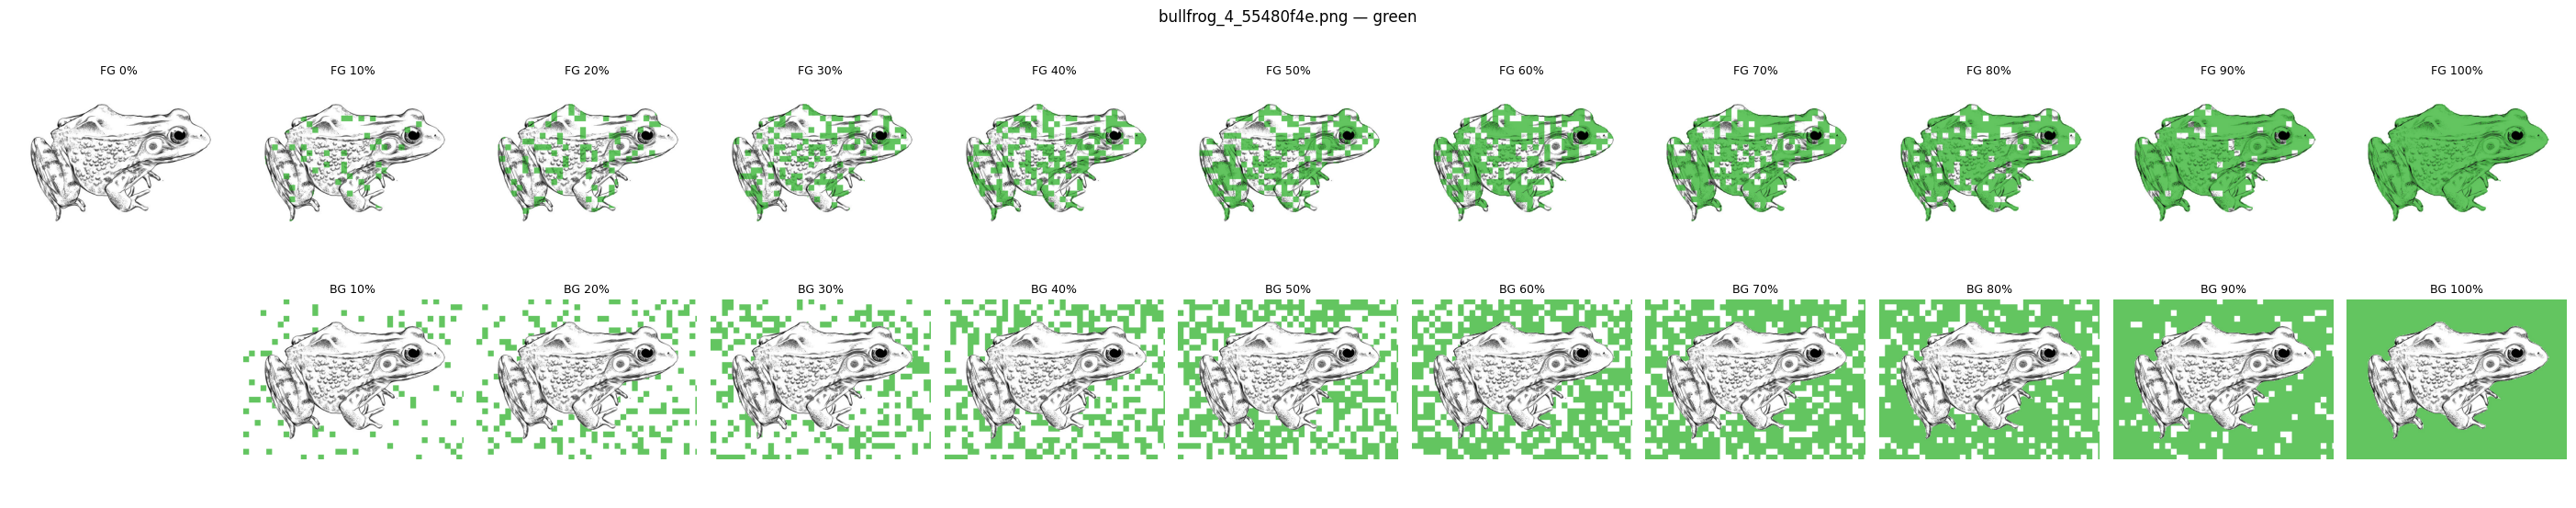

In [113]:
for idx, row in df.head().iterrows():
    target_colors = ast.literal_eval(row['correct_answer'])
    for tcol in target_colors:
        show_variants_grid(row['image_path'], tcol)

In [121]:
# Create variant labels from filenames (FG_XXX.png / BG_XXX.png)
def variant_label(p: Path):
    name = p.name
    if "FG_" in name:
        m = re.search(r"FG_(\d{3})", name)
        return f"FG {int(m.group(1))}%" if m else "FG"
    elif "BG_" in name:
        m = re.search(r"BG_(\d{3})", name)
        return f"BG {int(m.group(1))}%" if m else "BG"
    else:
        return "white"  # for uncolored base image

# Test one model on all variants of each outline image
results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    image_path = row["image_path"]
    target_colors = ast.literal_eval(row['correct_answer'])
    object_name = row["object"]

    for target_color in target_colors:
        variants = collect_variants_for(image_path, target_color, out_root=color_outlines)
        if not variants:
            continue

        # Build a dataframe for these variants
        df_variants = pd.DataFrame({
            "image_path": [str(p) for p in variants],
            "image_variant": [variant_label(p) for p in variants],
            "object": [object_name] * len(variants),
            "correct_answer": [target_color] * len(variants),
            "image_type": ["variant"] * len(variants),
        })

        # Run your VLM test on the variants
        df_tested = mllm_testing(df_variants, processor, model, most="False")
        # Keep only requested columns
        df_tested = df_tested[["image_variant", "object", "correct_answer", "predicted_color"]]

        results.append(df_tested)

  0%|          | 0/30 [00:00<?, ?it/s]


KeyError: 'correct_answer'

In [116]:
df_results = pd.concat(results, ignore_index=True)
#df_results.to_csv(data_folder / "outline_test_results.csv", index=False)
print(f"Saved results for {len(df_results)} image variants.")


Saved results for 21 image variants.


In [117]:
df_tested

,image_variant,object,correct_answer,predicted_color
0,FG 0%,bullfrog,green,grey
1,FG 10%,bullfrog,green,grey
2,FG 20%,bullfrog,green,grey
3,FG 30%,bullfrog,green,grey
4,FG 40%,bullfrog,green,grey
5,FG 50%,bullfrog,green,grey
6,FG 60%,bullfrog,green,grey
7,FG 70%,bullfrog,green,grey
8,FG 80%,bullfrog,green,grey
9,FG 90%,bullfrog,green,grey


In [106]:
# Example: show first outline image and its colored variants
first_row = df.iloc[0]
first_color = normalize_colors(first_row["correct_answer"])[0]
show_variants_grid(first_row["image_path"], first_color, out_root=color_outlines)

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/bullfrog_4_55480f4e.png


In [107]:
batch_size = 1
results = []

for i in tqdm(range(0, len(df), batch_size), desc="Running predictions"):
    batch_df = df.iloc[i:i + batch_size].copy()
    with torch.inference_mode():

        df_most = mllm_testing(batch_df, processor, model, most="True")
        df_most = df_most.rename(columns={"predicted_color": "pred_color_most"})

        df_this = mllm_testing(batch_df, processor, model, most="False")
        df_this = df_this.rename(columns={"predicted_color": "pred_color_this"})

        result_df = pd.merge(df_most, df_this, on=["image_path", "object", "image_type"])

    results.append(result_df)
    del result_df
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

df = pd.concat(results, ignore_index=True)
display(df)

Running predictions:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 'image_type'